In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


### Feature Engneering

#### Loading data

In [ ]:
df = spark.table("ecomm.olist_data_table_s").toPandas()
preprocess_and_build_model(df)

In [125]:
df.shape

(113760, 48)

In [126]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,8577,itaquaquecetuba,SP,office_furniture,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26,2017-05-30 22:34:40
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,8577,itaquaquecetuba,SP,office_furniture,7fc63200f12eebb5f387856afdd63db8,1.0,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29,2017-12-01 19:41:59
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,8577,itaquaquecetuba,SP,office_furniture,7fc63200f12eebb5f387856afdd63db8,1.0,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29,2017-12-01 19:41:59
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,8577,itaquaquecetuba,SP,office_furniture,251191809e37c1cffc16865947c18a4d,3.0,NaN,"Produto compatível com seu valor, muito bonito...",2017-05-27,2017-05-28 02:43:16
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,8577,itaquaquecetuba,SP,office_furniture,f7123bac5b91a0e2e38d8b41fd1206f4,4.0,NaN,Entregou antes do prazo,2018-03-01,2018-03-02 11:11:24


In [127]:
# Saving merge df as csv
#df.to_csv('merged.csv', index=False)

### Feature Engineering
RFM 

### I. Recency
How recently a customer has made a purchase or interacted with your business

1. The last purchase date of every individual customer is taken using the group by function.
2. Recency is calculated by subtracting the last recent date available in the dataset with every customer's last purchase date.

In [128]:
from datetime import datetime
# Finding most recent date of purchase
most_recent_date = df['order_purchase_timestamp'].max()

# Convert most_recent_date to a datetime object
most_recent_date = most_recent_date.to_pydatetime()
print('The last recent date in the available dataset is: ', most_recent_date)

The last recent date in the available dataset is:  2018-08-29 15:00:37


In [129]:
# Recency: 
df['recency'] = (most_recent_date - df['order_purchase_timestamp']).dt.days

In [130]:
# Creating new dataframe "recency"
recency = df[['customer_unique_id', 'order_purchase_timestamp', 'recency']].copy()
# Renaming columns
recency = recency.rename(columns={
    'order_purchase_timestamp': 'LastPurchaseDate'
})

In [131]:
recency.head()

,customer_unique_id,LastPurchaseDate,recency
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,469
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,293
2,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,293
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,478
4,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,206


In [132]:
recency.describe()

,LastPurchaseDate,recency
count,113760,113760.000000
mean,2018-01-01 03:25:28.922609152,239.958166
min,2016-10-03 09:44:50,0.000000
25%,2017-09-13 12:18:18.249999872,116.000000
50%,2018-01-19 19:51:37.500000,221.000000
75%,2018-05-05 08:30:34.500000,350.000000
max,2018-08-29 15:00:37,695.000000
std,NaN,152.886808


#####
Observations:
1. The average recency is approximately 239 days. This indicates that, on average, customers made their last purchase or engagement about 240 days ago.
2. The minimum recency value is 0.These customers represent very recent activity.
3. Customers with low recency values may be more receptive to promotions or re-engagement campaigns.
4. Higher recency values represents customers who have not made a purchase for an extended period. Strategies to re-engage or retain these      customers may be needed.
*Strategies to reduce customer's recencies:
1. Promotional Campaigns: Launch targeted promotional campaigns, such as discounts, special offers, or limited-time promotions
2. Loyalty Programs: Rewards customers for frequent purchases. Offer points, discounts, or exclusive access to encourage repeat business.
3. Reactivation Campaigns: Identify dormant customers (those with high recency values) and launch targeted reactivation campaigns. Provide special incentives or discounts to encourage them to return.
   



### II. Frequency

In [133]:
frequency = df.groupby('customer_unique_id')['order_id'].count()
df['frequency'] = df['customer_unique_id'].map(frequency)


In [134]:
# Creating a new dataframe "frequency"
frequency = df[['customer_unique_id','frequency']].copy()
frequency.head()

,customer_unique_id,frequency
0,861eff4711a542e4b93843c6dd7febb0,1
1,9eae34bbd3a474ec5d07949ca7de67c0,2
2,9eae34bbd3a474ec5d07949ca7de67c0,2
3,3c799d181c34d51f6d44bbbc563024db,1
4,23397e992b09769faf5e66f9e171a241,1


In [135]:
frequency['frequency'].unique()

array([ 1,  2,  6,  5,  3,  8,  4,  7, 10, 38, 12,  9, 15, 11, 14, 18, 75,
       24, 13, 21, 20, 19, 26, 16, 35, 22])

In [136]:
# Count of all frequencies
frequencyCount = frequency.frequency.value_counts(normalize=True)*100
#frequencyCount
frequency.describe()

,frequency
count,113760.000000
mean,1.819058
std,2.856051
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,75.000000


#### Observations:
1. The mean frequency is approximately 1.81, suggesting that, on average, customers make less than two purchases. 
   This indicates that a significant portion of the customer base tends to have infrequent purchase behavior.(~70%)
2. The maximum frequency of 75 suggests the presence of outliers, i.e., a few customers with exceptionally high purchase frequency. 
   These outliers could represent a specific segment of highly engaged or active customers.
3. Marketing Strategy Implications: For customers with a frequency of 1, strategies could focus on increasing engagement 
   and encouraging repeat purchases. For higher-frequency customers, loyalty programs or personalized offerings may be effective.

*To encourage one-time customers to make repeat purchases, businesses can implement:
1. Personalized Recommendations: Analyze the purchase history of one-time customers and provide personalized product recommendations based      on their preferences.
2. Loyalty Programs: Introduce a loyalty program that rewards customers for repeat purchases. Offer points, discounts, or exclusive perks       for every transaction.
3. Special Promotions: Create targeted promotions or exclusive offers for one-time customers. Provide time-limited discounts, buy-one-get-      one-free (BOGO) deals, or unique promotions to encourage them to make another purchase.
4. Post-Purchase Communication: Implement a strategic post-purchase communication strategy. Send personalized thank-you emails, follow-up        surveys, or feedback requests. Use these interactions to express appreciation, gather insights, and encourage future engagement.
5. Re-Engagement Campaigns: Design re-engagement campaigns specifically targeting one-time customers. Utilize email marketing, social media,    or other channels to remind them about your brand, showcase new products, and highlight any ongoing promotions.

### III. Monetary Value

In [137]:
monetary_value = df.groupby('customer_unique_id')['payment_value'].sum()
df['monetary_value'] = df['customer_unique_id'].map(monetary_value)
# Here payment value is addition of 'price' and 'freight_value'

In [138]:
# Creating a new dataframe "monetary"
monetary = df[['customer_unique_id','monetary_value']].copy()
monetary.head()

,customer_unique_id,monetary_value
0,861eff4711a542e4b93843c6dd7febb0,146.87
1,9eae34bbd3a474ec5d07949ca7de67c0,551.58
2,9eae34bbd3a474ec5d07949ca7de67c0,551.58
3,3c799d181c34d51f6d44bbbc563024db,140.61
4,23397e992b09769faf5e66f9e171a241,137.58


In [139]:
monetary.describe()

,monetary_value
count,113760.000000
mean,384.209051
std,1690.974045
min,9.590000
25%,70.610000
50%,134.595000
75%,282.747500
max,109312.640000


#### Observations:
1. The average monetary value per customer is 384. This represents the central tendency of spending across the customer base.
2. The standard deviation is relatively high at 1,690.97, indicating a wide dispersion in spending. 
   This suggests that customer spending varies significantly, and there may be outliers with exceptionally high monetary values.
3. The wide range in monetary values highlights the heterogeneity in customer spending habits.
4. The concentration of values in the lower quartiles (Q1 and Q2) suggests that a considerable portion of customers has relatively moderate     spending.
5. Identification and focus on high-value customers may lead to strategies that enhance customer retention and increase overall revenue.

* To gain more value from customers:
1. Personalized Marketing
2. Customer Segmentation: Segment customers based on their purchasing behavior, demographics, or preferences.
   Design targeted marketing strategies for each segment to address their specific needs and preferences.
3. Exclusive Offers for High-Value Customers

### IV. Customer Tenure

In [140]:
# finding the latest and earliest purchase dates for each customer
latest_purchase_date = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
earliest_purchase_date = df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()



In [141]:
# Calculate customer tenure in days
latest_purchase_date['customer_tenure'] = (latest_purchase_date['order_purchase_timestamp']- earliest_purchase_date['order_purchase_timestamp']).dt.days


In [142]:
df = pd.merge(df, latest_purchase_date[['customer_unique_id', 'customer_tenure']], on='customer_unique_id', how='left')

In [143]:
# Tenure
tenure = df[['customer_unique_id','customer_tenure']].copy()
#tenure[tenure['customer_tenure']==0].count()
tenure.describe()

,customer_tenure
count,113760.000000
mean,5.991350
std,37.565912
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,633.000000


### Observations:
1. The 25th, 50th (median), and 75th percentiles all have a value of 0. This indicates that a significant portion of customers has a 
   recorded tenure of 0, possibly implying that a considerable number of customers made a single purchase.
* To encourage customers to make repeated visits
1. Personalized Marketing
2. Special Offers for Returning Customers
3. Feedback and Surveys
4. Community Building: Encourage customers to share their experiences, create user-generated content, and participate in discussions. 


### V. Late deliveries


In [144]:
df['late_deliveries'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)
# total count of late deliveries for each customer
late_deliveries_count = df.groupby('customer_id')['late_deliveries'].sum().reset_index()

# Rename the column for clarity
late_deliveries_count = late_deliveries_count.rename(columns={'late_deliveries': 'total_late_deliveries'})

#late_deliveries_count['total_late_deliveries'].unique()
#late_deliveries_count.head()
df['late_deliveries'].value_counts()

late_deliveries
0    104871
1      8889
Name: count, dtype: int64

In [145]:
#To count number of late deliveries
#late_deliveries_count = df['late_deliveries'].eq(1).sum()
print("% of customer experienced late deliveries:",(8849 / 113102)*100 )

% of customer experienced late deliveries: 7.823911159838022


### VI. Number of orders


In [146]:
orders_per_customer = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()

# Rename the column for clarity
orders_per_customer = orders_per_customer.rename(columns={'order_id': 'num_orders'})

# Merge 'num_orders' back into the original DataFrame based on 'customer_unique_id'
df = pd.merge(df, orders_per_customer, on='customer_unique_id', how='left')



In [147]:
orders_per_customer['num_orders'].value_counts()

num_orders
1     89095
2      2513
3       174
4        29
5         9
6         3
7         3
9         1
14        1
Name: count, dtype: int64

In [148]:
df.to_csv('clv_data.csv',index = False)

In [149]:
# create a grouped DataFrame based on individual customers
grouped_df = df.groupby('customer_unique_id')\
.agg({'customer_zip_code_prefix'      : 'max',
'customer_city'                 : 'max',
'customer_state'                : 'max',
'order_id'                      : 'nunique',
'purchased_approved'            : 'mean',
'delivered_estimated'           : 'min',
'purchased_delivered'           : 'mean',
'product_id'                    : 'nunique',
'price'                         : 'sum',
'freight_value'                 : 'sum',
'payment_type'                  : 'max',
'payment_installments'          : 'max',
'payment_value'                 : 'sum',
'review_score'                  : 'mean',
'recency'                       : 'max',
'num_orders'                    : 'nunique',
'frequency'                     : 'mean',
'monetary_value'                : 'sum',
'customer_tenure'               : 'max',
'late_deliveries'               : 'sum'}).reset_index()

grouped_df.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,purchased_approved,delivered_estimated,purchased_delivered,product_id,price,...,payment_type,payment_installments,payment_value,review_score,recency,num_orders,frequency,monetary_value,customer_tenure,late_deliveries
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,cajamar,SP,1,891.0,4,6.0,1,129.90,...,credit_card,8,141.90,5.0,111,1,1.0,141.90,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,osasco,SP,1,26057.0,4,3.0,1,18.90,...,credit_card,1,27.19,4.0,114,1,1.0,27.19,0,0
2,0000f46a3911fa3c0805444483337064,88115,sao jose,SC,1,0.0,1,25.0,1,69.00,...,credit_card,8,86.22,3.0,536,1,1.0,86.22,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,66812,belem,PA,1,1176.0,11,20.0,1,25.99,...,credit_card,4,43.62,4.0,320,1,1.0,43.62,0,0
4,0004aac84e0df4da2b147fca70cf8255,18040,sorocaba,SP,1,1270.0,7,13.0,1,180.00,...,credit_card,6,196.89,5.0,287,1,1.0,196.89,0,0


### 
Creating a grouped DataFrame based on individual customers can be useful for various analyses and insights. 
1. Customer-Level Analysis
2. Segmentation
3. Churn Analysis
4. Customer Lifetime Value (CLV) Calculation
5. Identifying High-Value Customers

In [150]:
# Saving the dataframe as csv
grouped_df.to_csv('grouped_data.csv', index=False)

## RFM analysis

### Recency

In [151]:
recency.head()

,customer_unique_id,LastPurchaseDate,recency
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,469
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,293
2,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,293
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,478
4,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,206


In [152]:
recency[recency.recency == 0].count()

customer_unique_id    41
LastPurchaseDate      41
recency               41
dtype: int64

###

1. If the definition of churn is based on a customer not making any purchase for a certain period (e.g., no purchase in the last 30 days), 
  then customers with recency = 0 should not be considered as churned as they made a recent purchase.
2. but need to be dropped or changed to minimum value(=1) for furthur scaling and normalization.
   This would prevent division by zero issues during scaling and normalization.

####  1. Customer segmentation:
based on recency

In [153]:
# Customer segmentation:
bins = [-1, 60, 120, 220, float('inf')]
labels = ['Recent', 'Moderately Recent', 'Not So Recent', 'Inactive']
df['RecencySegment'] = pd.cut(df['recency'], bins=bins, labels=labels, right=False)


In [154]:
#df[df['RecencySegment'] == 'Moderately Recent'].count()
#df[df['RecencySegment'] == 'Recent'].count()
#df[df['RecencySegment'] == 'Inactive'].count()


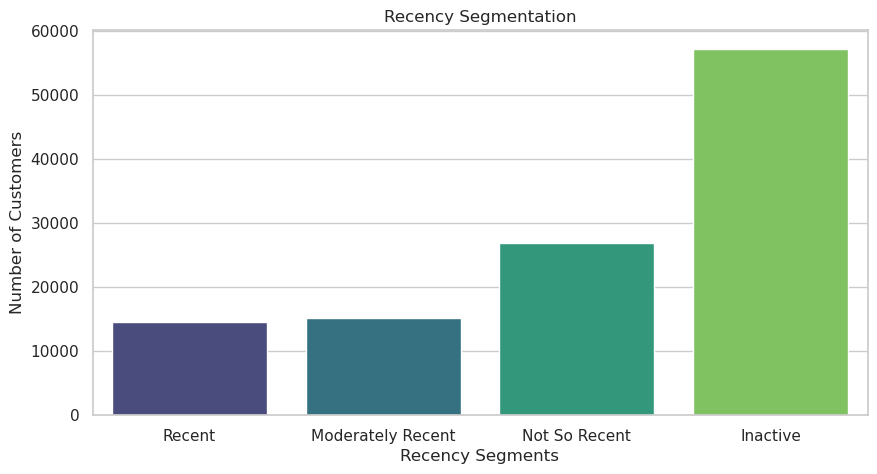

In [155]:
# Vizualizing customer segmentation(barchart)

# Set the style for the plot
sns.set(style="whitegrid")

# Plot the segmentation
plt.figure(figsize=(10, 5))
sns.countplot(x='RecencySegment', data=df, order=labels, palette='viridis')
plt.title('Recency Segmentation')
plt.xlabel('Recency Segments')
plt.ylabel('Number of Customers')
plt.show()


#### 2. Distribution of Recency


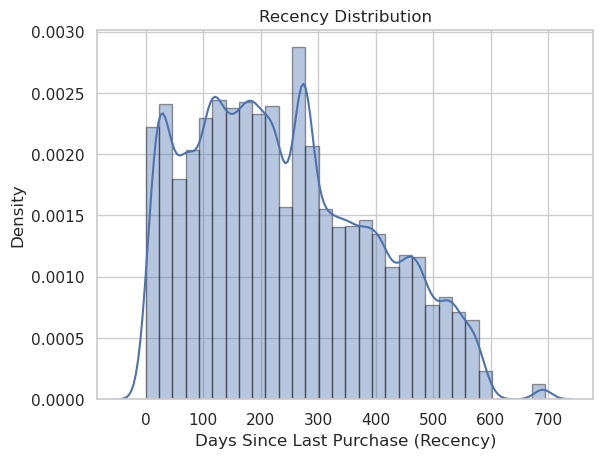

In [156]:
# Plot distribution plot with histogram and KDE
# Set the style for the plot
sns.set(style="whitegrid")

sns.distplot(recency['recency'], bins=30, kde=True, hist_kws={'edgecolor': 'black'})
plt.title("Recency Distribution")
plt.xlabel("Days Since Last Purchase (Recency)")
plt.ylabel("Density")
plt.show()


In [157]:
# Statistical description
recency['recency'].describe()

count    113760.000000
mean        239.958166
std         152.886808
min           0.000000
25%         116.000000
50%         221.000000
75%         350.000000
max         695.000000
Name: recency, dtype: float64

### Frequency

In [130]:
frequency.describe()

,frequency
count,113760.000000
mean,1.819058
std,2.856051
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,75.000000


Text(0.5, 0, "Frequency of customer's purchases")

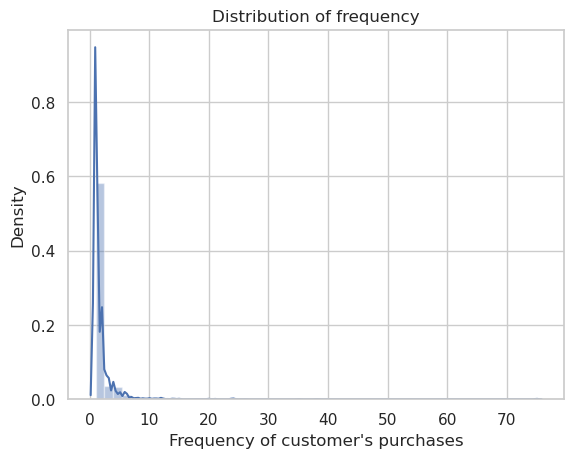

In [131]:
# Frequency distribution
sns.distplot(frequency.frequency)
plt.title("Distribution of frequency")
plt.xlabel("Frequency of customer's purchases")


#### Insights from frequency:
1. 25th Percentile (Q1): 25% of the customers have a frequency of 1 or less.
2. 50th Percentile (Median or Q2): The median frequency is 1, indicating that 50% of the customers made 1 or fewer purchases.
3. 75th Percentile (Q3): 75% of the customers have a frequency of 2 or less.
4. Maximum: The maximum frequency is 75, suggesting that there is at least one customer with a significantly higher number of purchases.

Interpretatin:
1. Distribution: The distribution of the frequency data is right-skewed, as the mean is greater than the median. 
   This indicates that there are some customers with a higher frequency of purchases, pulling the mean to the right.
2. Majority of Customers: The majority of customers (50% or more) make 1 or fewer purchases.
3. Variability: The relatively high standard deviation indicates variability in customer purchasing behavior.  
   Some customers make significantly more purchases than others.

### Monetary
amount of money spent by customers

In [132]:
# Statistical discription:
monetary['monetary_value'].describe()

count    113760.000000
mean        384.209051
std        1690.974045
min           9.590000
25%          70.610000
50%         134.595000
75%         282.747500
max      109312.640000
Name: monetary_value, dtype: float64

<Axes: xlabel='monetary_value', ylabel='Density'>

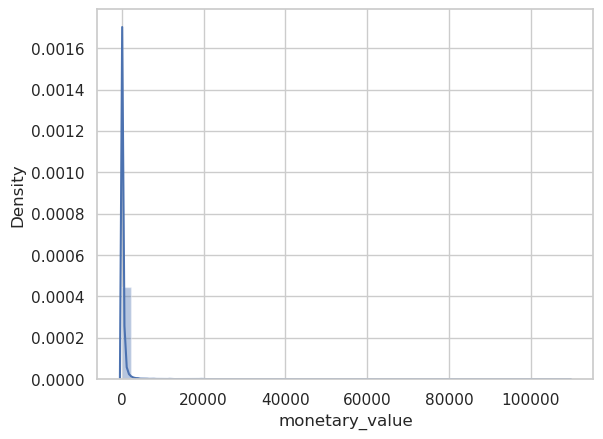

In [133]:
# Distribution of monetary
sns.distplot(monetary['monetary_value'])

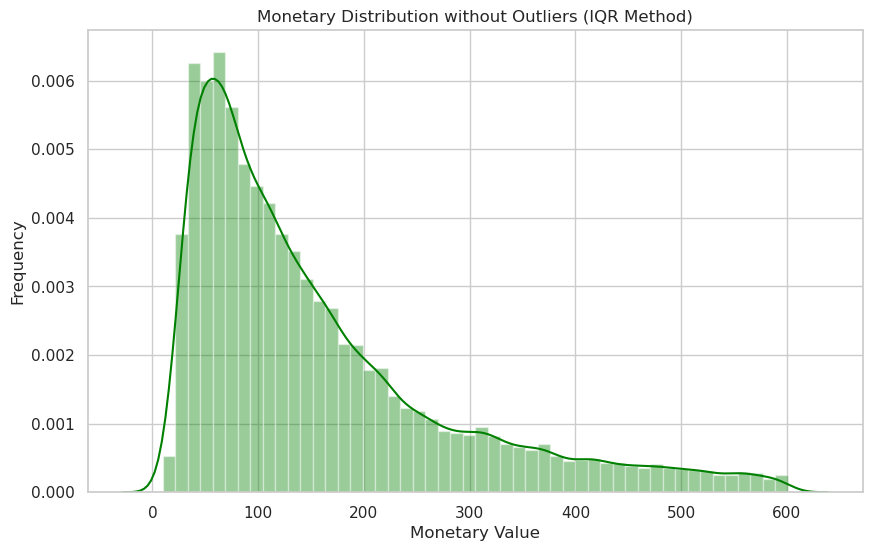

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the first and third quartiles (Q1 and Q3)
Q1 = monetary['monetary_value'].quantile(0.25)
Q3 = monetary['monetary_value'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out values outside the bounds to remove outliers
monetary_data_no_outliers = monetary['monetary_value'][(monetary['monetary_value'] >= lower_bound) \
& (monetary['monetary_value'] <= upper_bound)]

# Set the style for the plot (optional, but it enhances visual appearance)
sns.set(style="whitegrid")

# Plot histogram for data without outliers
plt.figure(figsize=(10, 6))
sns.distplot(monetary_data_no_outliers, color = 'green')
#sns.histplot(monetary_data_no_outliers, bins=30, kde=True, color='orange', edgecolor='black')
plt.title('Monetary Distribution without Outliers (IQR Method)')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.show()


In [135]:
monetary_data_no_outliers.describe()

count    100717.000000
mean        157.424193
std         125.467065
min           9.590000
25%          65.430000
50%         116.670000
75%         206.920000
max         600.750000
Name: monetary_value, dtype: float64

### Insights:
1. Mean: The mean (average) monetary value is approximately 157. On average, customers spend around 158.
2. Standard Deviation (std): The standard deviation is approximately 125. This indicates the amount of variability 
   or dispersion in the monetary data after removing outliers.
3. 25th Percentile (Q1): 25% of the customers spent 65.43 or less.
4. 50th Percentile (Median or Q2): The median monetary value is 116.67, indicating that 50% of the customers spent 115.81 or less.
5. 75th Percentile (Q3): 75% of the customers spent 206.92 or less.


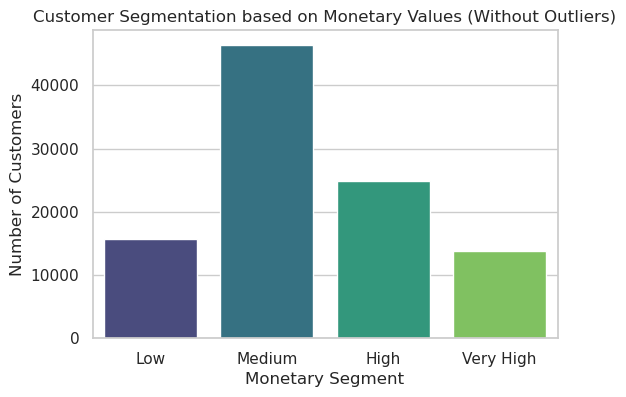

In [136]:
# Segmentation based on monetary values without outliers 
# Create a new column for segmentation
monetary['MonetarySegment'] = pd.cut(monetary_data_no_outliers, bins=[0, 50, 150, 300, 600], labels=['Low', 'Medium', 'High', 'Very High'])

# Visualize segmentation
plt.figure(figsize= (6, 4))
sns.countplot(x='MonetarySegment', data=monetary, palette='viridis')
plt.title('Customer Segmentation based on Monetary Values (Without Outliers)')
plt.xlabel('Monetary Segment')
plt.ylabel('Number of Customers')
plt.show()

### Customer tenure


In [137]:
tenure['customer_tenure'].describe()

count    113760.000000
mean          5.991350
std          37.565912
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         633.000000
Name: customer_tenure, dtype: float64

#### Calculate customer lifetime value based on customer tenure
The total value a customer is expected to bring to a business over their entire relationship

In [138]:
# Calculate average purchase value
average_purchase_value = df['monetary_value'].mean()

# Calculate average purchase frequency
purchase_frequency = df['frequency'].mean()

# Calculate average customer lifespan (in days)
average_customer_lifespan = df['customer_tenure'].mean()

# Calculate historical CLV
historical_clv = average_purchase_value * purchase_frequency * average_customer_lifespan

print('Expected value a customer bring to business based on data: ', round(historical_clv, 2), 'brazillian real')


Expected value a customer bring to business based on data:  4187.35 brazillian real


In [139]:
df['customer_tenure'].unique()

array([  0, 138,  51, 122, 123,  68, 172,  38,  53,  80,  24,  91,  23,
       142,   3, 139, 340, 347,  81,  42, 237,  48,   4, 167, 379, 125,
       329,   2,  10,  17,  16, 279,   1, 345, 514,  39, 327, 148, 281,
       100,  18,  40,  62,  11,  20,   8, 398,   7, 168,  44, 218,   9,
       165, 220, 246,  50,  15,   6,  97, 312,  65, 230, 234, 311, 212,
        69,  83,  12,  55,  32,  49, 302, 169, 409, 328, 265, 102, 173,
       401, 238, 161, 113,  43,  59, 382,  28,  90, 133, 255,  85, 162,
         5, 252, 282, 356, 313, 214, 205, 582, 361, 121, 420, 186,  25,
       462, 171, 266,  19, 112, 198, 326, 177, 103,  34,  77,  13,  30,
       151, 204, 270,  94, 147, 149,  76, 292, 145, 213, 353,  88, 158,
        61, 152, 483, 202, 432, 206, 341,  26,  14, 307,  29,  33, 134,
       229, 156, 273, 166,  21,  35, 155, 342,  75, 185,  57,  92, 310,
       280, 488, 163, 283, 245, 124, 181, 175,  56, 114, 572,  27, 262,
       303, 232,  58,  79, 141,  45, 308, 159, 404, 184,  64,  7

### Late deliveries

In [140]:
late_deliveries_count['total_late_deliveries'].unique()
#late_deliveries_count[late_deliveries_count['total_late_deliveries']==9].count()

array([ 0,  1,  2,  7,  6,  4,  3,  5,  8, 21])

In [141]:
# Segment customers based on the total count of late deliveries
bins = [-1, 0, 3, float('inf')]
labels = ['No Late Deliveries', 'Low', 'High']
late_deliveries_count['LateDeliverySegment'] = pd.cut(late_deliveries_count['total_late_deliveries'], bins=bins, labels=labels)

# Display the segmentation results
print(late_deliveries_count['LateDeliverySegment'].value_counts())


LateDeliverySegment
No Late Deliveries    87188
Low                    7592
High                     86
Name: count, dtype: int64


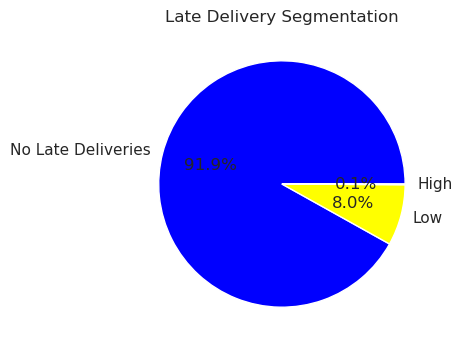

In [142]:
# late deliveries segmentation
segment_counts = late_deliveries_count['LateDeliverySegment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 4))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=['blue', 'yellow', 'red'])
plt.title('Late Delivery Segmentation')
plt.show()

In [143]:
late_deliveries_count.describe()

,total_late_deliveries
count,94866.000000
mean,0.093701
std,0.356758
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,21.000000


In [144]:
reviewScore = df['review_score'].value_counts(normalize = True) * 100
reviewScore


review_score
5.0    57.550128
4.0    19.268103
1.0    11.364603
3.0     8.424260
2.0     3.392908
Name: proportion, dtype: float64

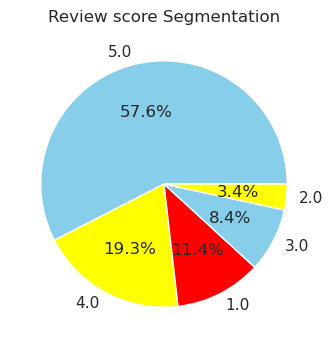

In [147]:
# Plot a pie chart
plt.figure(figsize=(6, 4))
plt.pie(reviewScore, labels=reviewScore.index, autopct='%1.1f%%', colors=['skyblue', 'yellow', 'red'])
plt.title('Review score Segmentation')
plt.show()

#### Observation
1. The majority of customers are highly satisfied, as indicated by the high percentage in the 5.0 category.
2. A notable portion of customers gave scores indicating moderate to high satisfaction (4.0).
3. Around 23% of customers are not satified.

### Impact on customer satisfaction from late deliveries

In [148]:
# Customers satisfaction based on late deliveries

reviewScoreAnalysis = orderReviews_df[['order_id', 'review_score']]\
.merge(orders_df[['order_id', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']], on = 'order_id')
reviewScoreAnalysis.head()

,order_id,review_score,approved_carrier,carrier_delivered,delivered_estimated,purchased_delivered
0,73fc7af87114b39712e6da79b0a377eb,4,1,4,15,6
1,a548910a1c6147796b98fdf73dbeba33,5,2,7,4,9
2,f9e4b658b201a9f2ecdecbb34bed034b,5,3,10,20,13
3,658677c97b385a9be170737859d3511b,5,0,9,19,10
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,5,12,8,18


In [149]:
ontimeDelivery_review = reviewScoreAnalysis[reviewScoreAnalysis.delivered_estimated > 0][['review_score', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']].mean()
lateDelivery_review = reviewScoreAnalysis[reviewScoreAnalysis.delivered_estimated < 0][['review_score', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']].mean()
comparision_review = pd.DataFrame([ontimeDelivery_review, lateDelivery_review]).T
comparision_review.rename(columns = {0 : 'on time delivery', 1 : 'late delivery'}, inplace = True)
comparision_review

,on time delivery,late delivery
review_score,4.296071,2.567125
approved_carrier,2.000872,4.847702
carrier_delivered,7.344992,25.072708
delivered_estimated,12.935816,-9.794469
purchased_delivered,10.307470,30.964295


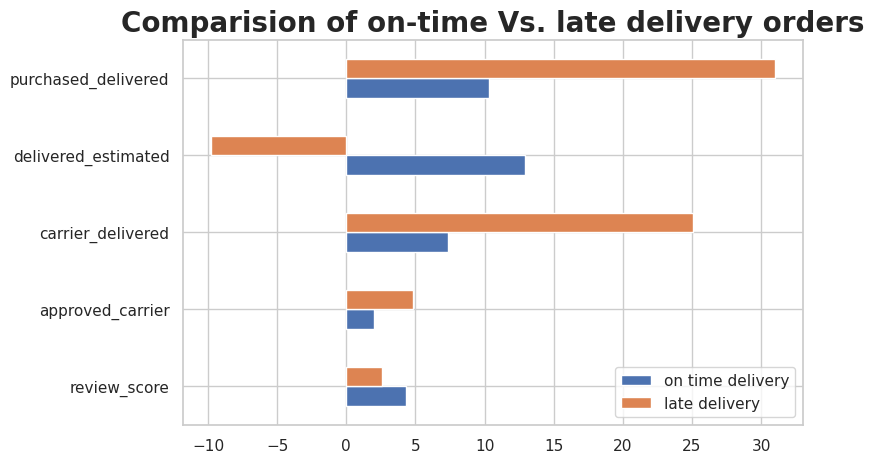

In [150]:
comparision_review.plot(kind = 'barh', figsize = (8, 5))
plt.title('Comparision of on-time Vs. late delivery orders',fontweight='bold',fontsize=20)
plt.show()


#### Interpretation: 
1. On-Time Delivery Average Review Score: 4.296071
   Customers who received their deliveries on time gave an average review score of approximately 4.04. 
   This indicates a relatively high level of satisfaction among customers who experienced on-time deliveries.

2. Late Delivery Average Review Score: 2.567125.
   Customers who experienced late deliveries gave an average review score of approximately 2.56. 
   This suggests a lower level of satisfaction among customers who faced delays in their deliveries.
3. Timely delivery appears to be positively correlated with higher customer satisfaction.
4. Late deliveries may have a negative impact on the overall customer experience, leading to lower review scores.
5. It took 25 days on an average for the orders to get delivered to the customers for late delivery orders, 
   while it took just 9 days for on-time delivery orders.
6. On an average, orders were delivered 14 days before the estimated date of delivery for on-time delivered orders.


#### Business insights:

1. Carrier Selection: Emphasize the importance of selecting and using approved carriers, as they seem to contribute to better on-time performance and higher customer satisfaction.

2. Operational Efficiency: Focus on improving operational efficiency for carriers involved in the delivery process to reduce the time gap between the estimated and actual delivery times.

3. Customer Satisfaction: Timely deliveries positively impact customer satisfaction. Implement strategies to enhance on-time delivery performance, as it correlates with higher review scores.

4. Communication and Expectations: Ensure accurate estimation of delivery times and communicate them clearly to customers. This can help manage customer expectations and reduce dissatisfaction associated with late deliveries.

### Creating a new dataframe for rfm analsis

In [151]:
rfm_df = df[['customer_id','recency','frequency','monetary_value']]
rfm_df.head()

,customer_id,recency,frequency,monetary_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,469,1,146.87
1,8912fc0c3bbf1e2fbf35819e21706718,293,2,551.58
2,8912fc0c3bbf1e2fbf35819e21706718,293,2,551.58
3,f0ac8e5a239118859b1734e1087cbb1f,478,1,140.61
4,6bc8d08963a135220ed6c6d098831f84,206,1,137.58


In [152]:
#### Saving rfm_df as csv on dir: Project_X
rfm_df.to_csv('rfm_df.csv', index=False)


In [153]:
final = df[['customer_id','customer_unique_id','recency','frequency','monetary_value','customer_tenure',\
            'late_deliveries','num_orders','review_score','review_comment_title']]


In [154]:
### Saving final as csv
final.to_csv('rfm_addf.csv',index=False)

In [155]:
final.head()

,customer_id,customer_unique_id,recency,frequency,monetary_value,customer_tenure,late_deliveries,num_orders,review_score,review_comment_title
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,469,1,146.87,0,0,1,4.0,NaN
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,293,2,551.58,0,0,1,1.0,NaN
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,293,2,551.58,0,0,1,1.0,NaN
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,478,1,140.61,0,0,1,3.0,NaN
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,206,1,137.58,0,0,1,4.0,NaN


#### More analysis on additional features

In [156]:
# Descriptive Statistics
descriptive_stats = final.describe()
print("Descriptive Statistics:")
print(descriptive_stats)


Descriptive Statistics:
             recency      frequency  monetary_value  customer_tenure  \
count  113760.000000  113760.000000   113760.000000    113760.000000   
mean      239.958166       1.819058      384.209051         5.991350   
std       152.886808       2.856051     1690.974045        37.565912   
min         0.000000       1.000000        9.590000         0.000000   
25%       116.000000       1.000000       70.610000         0.000000   
50%       221.000000       1.000000      134.595000         0.000000   
75%       350.000000       2.000000      282.747500         0.000000   
max       695.000000      75.000000   109312.640000       633.000000   

       late_deliveries     num_orders   review_score  
count    113760.000000  113760.000000  112912.000000  
mean          0.078138       1.086428       4.082462  
std           0.268390       0.382782       1.345916  
min           0.000000       1.000000       1.000000  
25%           0.000000       1.000000       4.000000

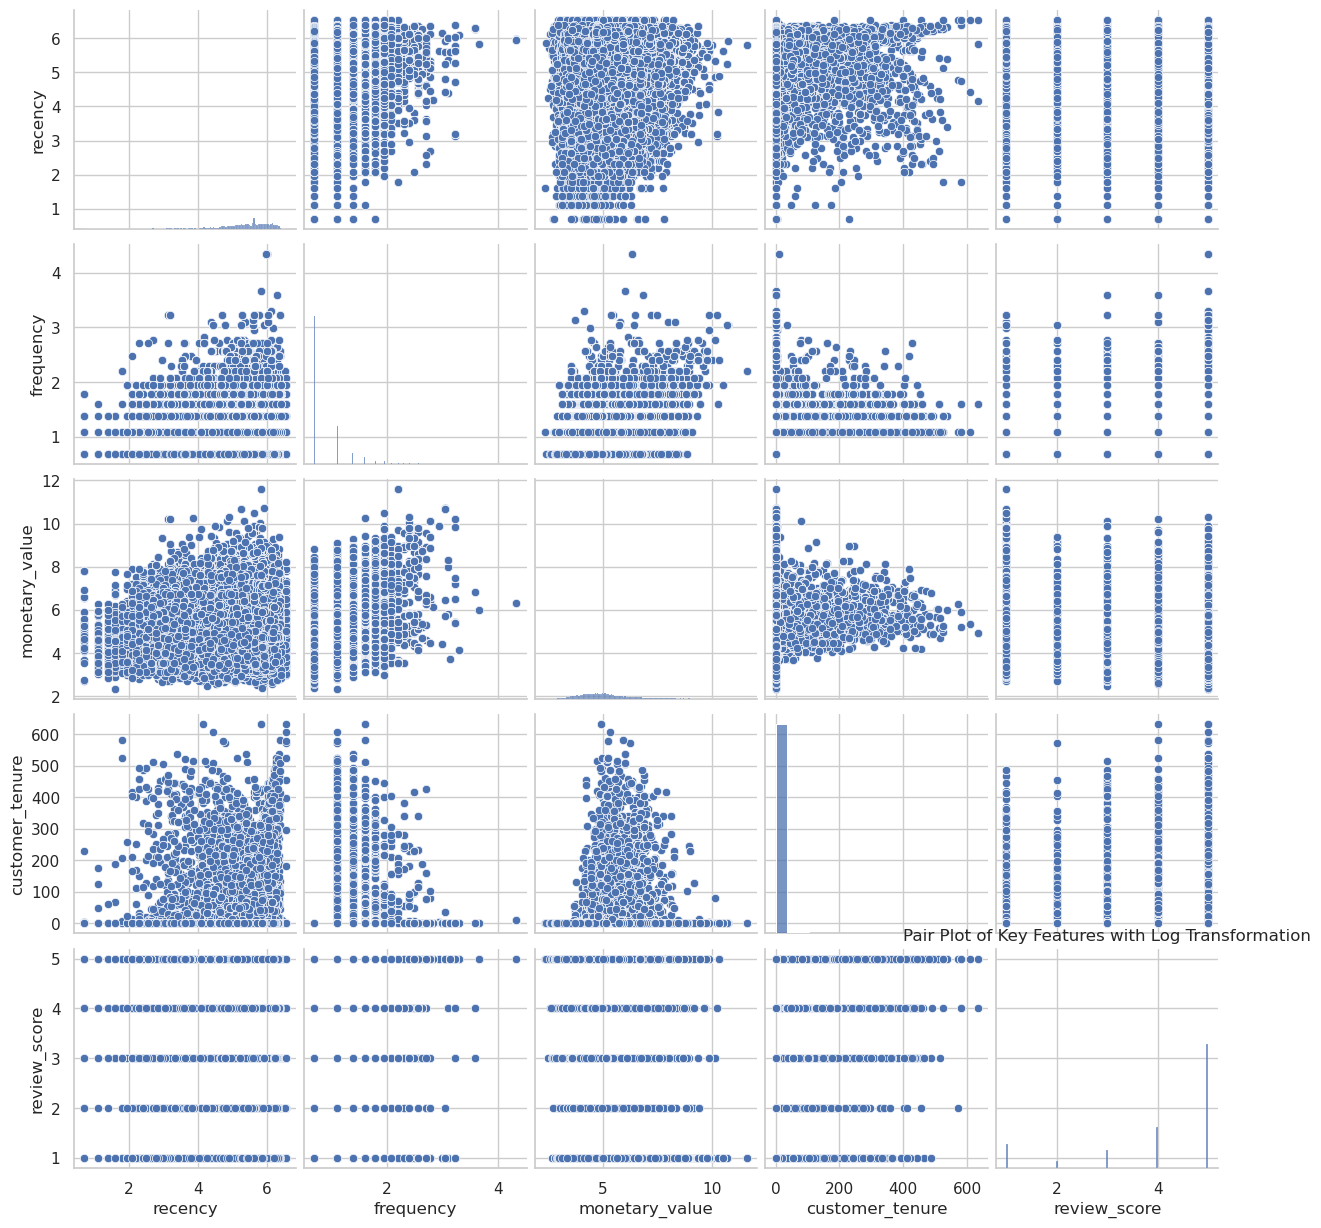

In [157]:
# Pair Plot for Key Features
# recency, monetary_value and frequency is right skewed 
# Log transformation can help mitigate the impact of extreme values, making the distribution more symmetric
# Add 1 to 'recency' to handle zero values
#the minimum recency is 0, indicating that some customers made a purchase on the same day. 
#Log transformation may not be suitable for zero values.

# Create a copy of the original DataFrame
final_transformed = final.copy()
final_transformed['recency'] = final_transformed['recency'] + 1

# Log transform 'recency', 'frequency', and 'monetary_value' with addition of 1
columns_to_log_transform = ['recency', 'frequency', 'monetary_value']
final_transformed[columns_to_log_transform] = np.log1p(final_transformed[columns_to_log_transform])

# Pair Plot for Key Features with log-transformed values
sns.pairplot(final_transformed[['recency', 'frequency', 'monetary_value', 'customer_tenure', 'review_score']])
plt.title('Pair Plot of Key Features with Log Transformation')
plt.show()



#### Descriptive statistics after log transsformation

In [158]:
# Add a small constant (e.g., 1) to 'recency' to handle zero values
final_transformed['recency'] = final_transformed['recency'] + 1

# Log transform 'recency', 'frequency', and 'monetary_value' with addition of 1
columns_to_log_transform = ['recency', 'frequency', 'monetary_value']
final_transformed[columns_to_log_transform] = np.log1p(final_transformed[columns_to_log_transform])

final_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113760 entries, 0 to 113759
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   customer_id           113760 non-null  object 
 1   customer_unique_id    113760 non-null  object 
 2   recency               113760 non-null  float64
 3   frequency             113760 non-null  float64
 4   monetary_value        113760 non-null  float64
 5   customer_tenure       113760 non-null  int64  
 6   late_deliveries       113760 non-null  int64  
 7   num_orders            113760 non-null  int64  
 8   review_score          112912 non-null  float64
 9   review_comment_title  13453 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 8.7+ MB


#### Correlation matrix


In [159]:
# Compute correlation matrix
columns_to_drop = ['review_comment_title', 'customer_unique_id', 'customer_id']
corr_final = final_transformed.drop(columns = columns_to_drop, axis=1)
correlation_matrix = corr_final.corr()
# Print result
correlation_matrix



,recency,frequency,monetary_value,customer_tenure,late_deliveries,num_orders,review_score
recency,1.000000,0.048696,0.015588,0.015149,-0.009650,0.037908,-0.037303
frequency,0.048696,1.000000,0.569589,0.235133,-0.033795,0.401536,-0.139221
monetary_value,0.015588,0.569589,1.000000,0.137829,0.000407,0.218663,-0.140031
customer_tenure,0.015149,0.235133,0.137829,1.000000,-0.016529,0.595439,0.024853
late_deliveries,-0.009650,-0.033795,0.000407,-0.016529,1.000000,-0.014825,-0.329059
num_orders,0.037908,0.401536,0.218663,0.595439,-0.014825,1.000000,0.016557
review_score,-0.037303,-0.139221,-0.140031,0.024853,-0.329059,0.016557,1.000000


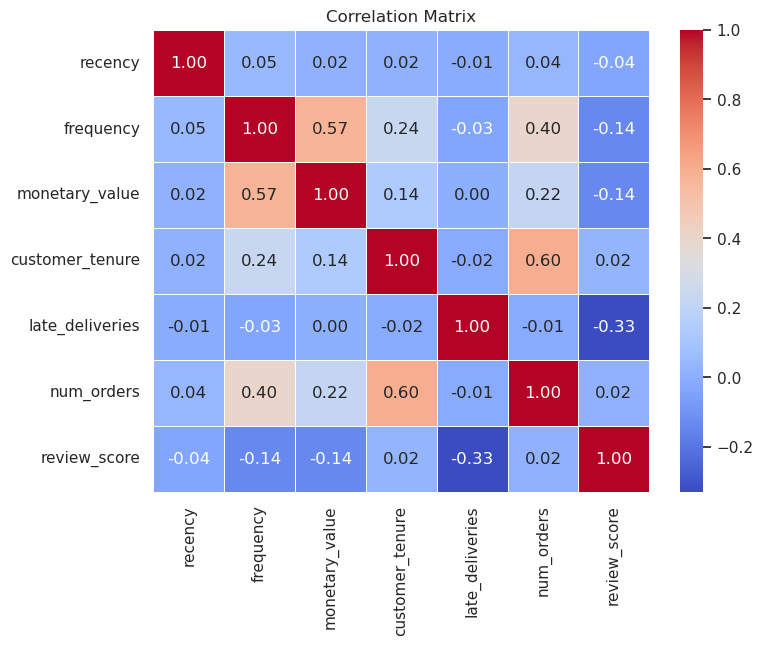

In [160]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


### Insights:
1. Recency Correlations:
        recency has a weak positive correlation with frequency (0.05). This suggests that more recent customers might tend to make purchases more frequently.

2. Frequency Correlations:
        frequency has a moderate positive correlation with both monetary_value (0.57) and num_orders (0.40). This indicates that customers who make more frequent purchases tend to spend more and place a higher number of orders.

3. Monetary Value Correlations:
        monetary_value has a moderate positive correlation with frequency (0.57) and a weaker positive correlation with num_orders (0.22). This reinforces the idea that customers who spend more in each transaction also tend to make more frequent purchases.

4. Customer Tenure Correlations:
        customer_tenure has a weak positive correlation with both num_orders (0.60) and recency (0.02). This suggests that longer-tenured customers tend to make more orders and might also have more recent purchases.

5. Late Deliveries Correlations:
        late_deliveries has a weak negative correlation with review_score (-0.33). This indicates that customers who experience more late deliveries are likely to give lower review scores.

6. Review Score Correlations:
        review_score has a weak negative correlation with both frequency (-0.14) and monetary_value (-0.14). This suggests that customers who make less frequent purchases or spend less might be more critical and give lower review scores.

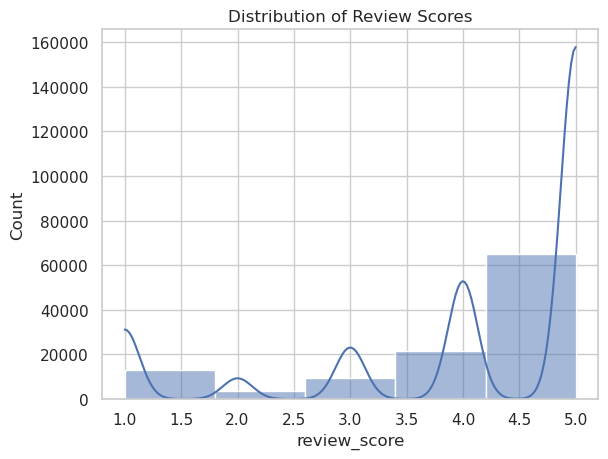

In [161]:
# Customer Segmentation Based on Review Score
sns.histplot(final, x='review_score', bins=5, kde=True)
plt.title('Distribution of Review Scores')
plt.show()


#### Churn analysis on final

In [162]:
final.head()

,customer_id,customer_unique_id,recency,frequency,monetary_value,customer_tenure,late_deliveries,num_orders,review_score,review_comment_title
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,469,1,146.87,0,0,1,4.0,NaN
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,293,2,551.58,0,0,1,1.0,NaN
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,293,2,551.58,0,0,1,1.0,NaN
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,478,1,140.61,0,0,1,3.0,NaN
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,206,1,137.58,0,0,1,4.0,NaN


Churn Analysis:
  churn  monetary_value  frequency  customer_tenure  late_deliveries  \
0     0      371.869679   1.675768         5.304431         0.083391   
1     1      392.541907   1.915822         6.455231         0.074591   

   num_orders  
0    1.067123  
1    1.099464  


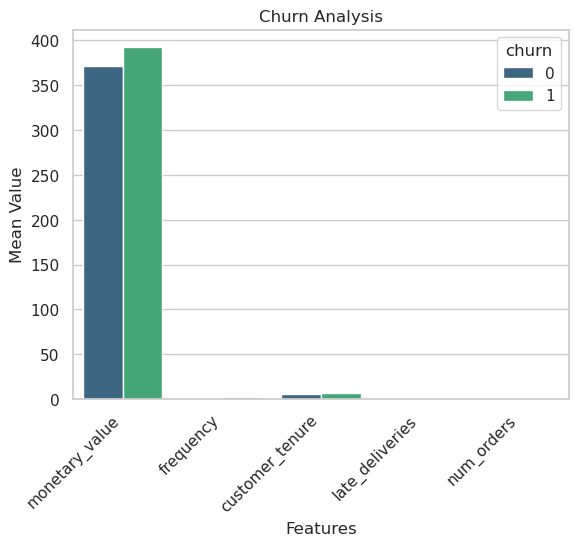

In [163]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming a threshold for 'recency'
churn_threshold_days = 180
final['churn'] = (final['recency'] > churn_threshold_days).astype(int).astype(str)

# Analyze features for churn prediction
churn_analysis = final.groupby('churn').agg({
    'monetary_value': 'mean',
    'frequency': 'mean',
    'customer_tenure': 'mean',
    'late_deliveries': 'mean',
    'num_orders': 'mean'
}).reset_index()

# Print insights
print("Churn Analysis:")
print(churn_analysis)

# Visualize Churn Analysis without log-transformed features
churn_analysis_melted = pd.melt(churn_analysis, id_vars='churn', var_name='feature', value_name='mean_value')
sns.barplot(data=churn_analysis_melted, x='feature', y='mean_value', hue='churn', palette='viridis')
plt.title('Churn Analysis')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')
plt.show()

Churn Analysis:
  churn  monetary_value  frequency  customer_tenure  late_deliveries  \
0     0       -0.007297  -0.050171        -0.018286         0.019573   
1     1        0.004928   0.033881         0.012349        -0.013218   

   num_orders  
0   -0.050432  
1    0.034057  


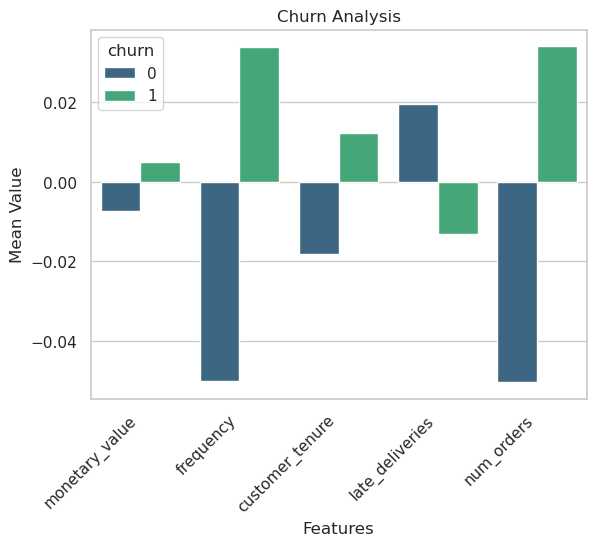

In [164]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming a threshold for 'recency'
churn_threshold_days = 180
final['churn'] = (final['recency'] > churn_threshold_days).astype(int).astype(str)

# Features for churn prediction
features_for_churn = ['monetary_value', 'frequency', 'customer_tenure', 'late_deliveries', 'num_orders']

# Standardize features
scaler = StandardScaler()
final[features_for_churn] = scaler.fit_transform(final[features_for_churn])

# Analyze features for churn prediction
churn_analysis = final.groupby('churn').agg({
    'monetary_value': 'mean',
    'frequency': 'mean',
    'customer_tenure': 'mean',
    'late_deliveries': 'mean',
    'num_orders': 'mean'
}).reset_index()

# Print insights
print("Churn Analysis:")
print(churn_analysis)

# Visualize Churn Analysis without log-transformed features
churn_analysis_melted = pd.melt(churn_analysis, id_vars='churn', var_name='feature', value_name='mean_value')
sns.barplot(data=churn_analysis_melted, x='feature', y='mean_value', hue='churn', palette='viridis')
plt.title('Churn Analysis')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')
plt.show()

### Insights:
1. Monetary Value:
        Customers who churned (churn = 1) have a positive standardized value for monetary value (0.0049), indicating that they tend to have a slightly higher monetary value compared to those who did not churn (churn = 0). However, the difference is relatively small.

2. Frequency:
        Customers who churned have a positive standardized value for frequency (0.03), suggesting that they tend to make purchases more frequently compared to those who did not churn.

3. Customer Tenure:
        Customers who churned have a positive standardized value for customer tenure (0.012309), indicating that they tend to have a slightly longer tenure compared to those who did not churn.

4. Late Deliveries:
        Customers who churned have a negative standardized value for late deliveries (-0.013), suggesting that they tend to experience slightly fewer late deliveries compared to those who did not churn.

5. Number of Orders:
        Customers who churned have a positive standardized value for the number of orders (0.034), indicating that they tend to place a slightly higher number of orders compared to those who did not churn.


# Perform RFM analysis


In [165]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113760 entries, 0 to 113759
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   customer_id     113760 non-null  object 
 1   recency         113760 non-null  int64  
 2   frequency       113760 non-null  int64  
 3   monetary_value  113760 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.5+ MB


In [166]:
# Bin RFM values
# Recency Binning
rfm_df['recency_score'] = pd.qcut(rfm_df['recency'], q=4, labels=False, duplicates='drop')

# Frequency Binning
rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency'], q=4, labels=False, duplicates='drop')

# Monetary Binning
rfm_df['monetary_score'] = pd.qcut(rfm_df['monetary_value'], q=4, labels=False, duplicates='drop')


### 

The q=4 parameter in the pd.qcut function suggests that the 'recency' values are being divided into four equal quantiles. 
Quantiles are points in a dataset that divide it into groups of equal probability or size.
Each quantile will represent a different level of recency, with the goal of capturing variations in customer behavior based on recency.

In [167]:
# Calculate RFM score
rfm_df['rfm_score'] = rfm_df['recency_score'] + rfm_df['frequency_score'] + rfm_df['monetary_score']
rfm_df.head()

,customer_id,recency,frequency,monetary_value,recency_score,frequency_score,monetary_score,rfm_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,469,1,146.87,3,0,2,5
1,8912fc0c3bbf1e2fbf35819e21706718,293,2,551.58,2,0,3,5
2,8912fc0c3bbf1e2fbf35819e21706718,293,2,551.58,2,0,3,5
3,f0ac8e5a239118859b1734e1087cbb1f,478,1,140.61,3,0,2,5
4,6bc8d08963a135220ed6c6d098831f84,206,1,137.58,1,0,2,3


In [168]:
rfm_df.rfm_score.value_counts()

rfm_score
3    25378
4    21244
2    20648
5    14383
1    14261
6     7831
0     7037
7     2978
Name: count, dtype: int64

### RFM score:
1. A higher RFM score typically indicates a more favorable customer behavior.
2. Recency (R):
   High Score: The customer has made a purchase very recently.
   Recent customers are often more engaged and have a higher likelihood of making additional purchases.
3. Frequency (F): High Score: The customer makes frequent purchases. High-frequency customers are loyal and consistently engaged with your business, indicating a strong relationship.
4. Monetary (M): High Score: The customer has a higher monetary value, indicating higher spending. High monetary value suggests that the customer is a high spender, contributing significantly to your revenue.

#### When combining these components into an overall RFM score, a higher total RFM score implies that a customer is recent, makes frequent purchases, and has a high monetary value. Therefore, customers with high RFM scores are often considered the most valuable and desirable for a business.

<Figure size 1200x800 with 0 Axes>

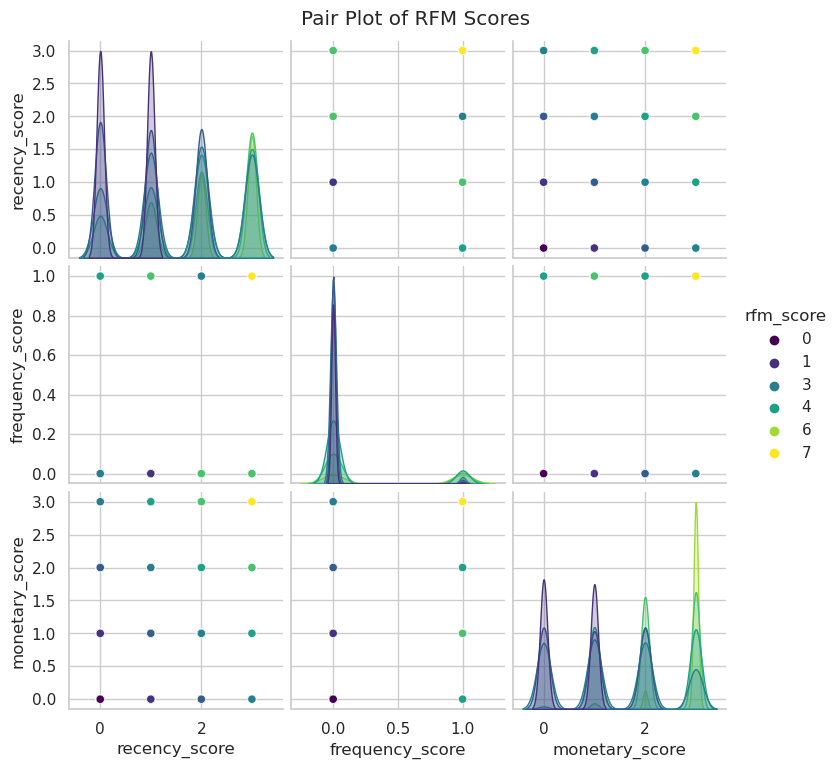

In [169]:
# Visualize rfm analysis
plt.figure(figsize=(12, 8))

# Pair plot
sns.pairplot(rfm_df[['recency_score', 'frequency_score', 'monetary_score', 'rfm_score']], hue='rfm_score', palette='viridis', markers='o')

# Set title
plt.suptitle('Pair Plot of RFM Scores', y=1.02)

plt.show()


In [170]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate correlation matrix
correlation_matrix = rfm_df[['recency_score', 'frequency_score', 'monetary_score', 'rfm_score']].corr()

#Print correlation matrix:
correlation_matrix


,recency_score,frequency_score,monetary_score,rfm_score
recency_score,1.000000,0.030620,0.003657,0.658990
frequency_score,0.030620,1.000000,0.393047,0.475834
monetary_score,0.003657,0.393047,1.000000,0.731709
rfm_score,0.658990,0.475834,0.731709,1.000000


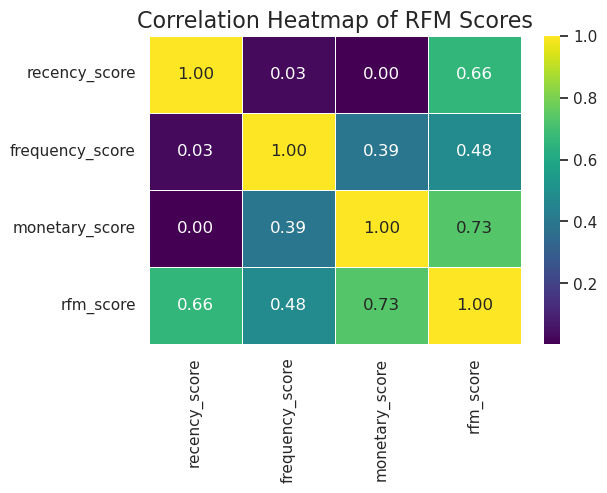

In [172]:
# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of RFM Scores', fontsize=16)
plt.show()


### Interpretations:
1. The RFM score is strongly influenced by monetary value, with a notable positive correlation.
2. Recency has a moderate positive impact on the overall RFM score, but the relationship is not as strong as monetary value.
3. Frequency has a moderate positive impact on both monetary value and the overall RFM score.
4. Therefore, we will use rfm_score to decide churn

In [173]:
#rfm_df.isna().sum()
rfm_df.describe()

,recency,frequency,monetary_value,recency_score,frequency_score,monetary_score,rfm_score
count,113760.000000,113760.000000,113760.000000,113760.000000,113760.000000,113760.000000,113760.000000
mean,239.958166,1.819058,384.209051,1.495939,0.137131,1.499965,3.133034
std,152.886808,2.856051,1690.974045,1.117780,0.343987,1.118070,1.718389
min,0.000000,1.000000,9.590000,0.000000,0.000000,0.000000,0.000000
25%,116.000000,1.000000,70.610000,0.000000,0.000000,0.000000,2.000000
50%,221.000000,1.000000,134.595000,1.000000,0.000000,1.500000,3.000000
75%,350.000000,2.000000,282.747500,2.000000,0.000000,2.250000,4.000000
max,695.000000,75.000000,109312.640000,3.000000,1.000000,3.000000,7.000000


In [174]:
from scipy.stats import f_oneway
# Extract the scores for each group
grouped_data = [rfm_df[rfm_df['rfm_score'] == score]['monetary_score'] for score in rfm_df['rfm_score'].unique()]

# Perform ANOVA
anova_result = f_oneway(*grouped_data)

# Print the ANOVA result
print("ANOVA Result:")
print(anova_result)


ANOVA Result:
F_onewayResult(statistic=19185.296282109295, pvalue=0.0)


In [175]:
from scipy.stats import f_oneway

# Extract the scores for each group
grouped_data = [rfm_df[rfm_df['rfm_score'] == score]['recency_score'] for score in rfm_df['rfm_score'].unique()]

# Perform ANOVA
anova_result = f_oneway(*grouped_data)

# Print the ANOVA result
print("ANOVA Result:")
print(anova_result)


ANOVA Result:
F_onewayResult(statistic=13019.792412220007, pvalue=0.0)


In [176]:
from scipy.stats import f_oneway

# Assuming rfm_df is your DataFrame containing recency_score, frequency_score, monetary_score, and rfm_score columns
# Extract the scores for each group
grouped_data = [rfm_df[rfm_df['rfm_score'] == score]['frequency_score'] for score in rfm_df['rfm_score'].unique()]

# Perform ANOVA
anova_result = f_oneway(*grouped_data)

# Print the ANOVA result
print("ANOVA Result:")
print(anova_result)


ANOVA Result:
F_onewayResult(statistic=7869.095233372852, pvalue=0.0)


### Interpretations:
1. The extremely large F-statistic suggests that there are significant differences between the means of the groups 
   (likely different levels of monetary/recency/frequency scores).
2. The very small p-value (0.0) indicates that the observed differences are highly unlikely to have occurred by random chance alone.
3. Therefore, we reject the null hypothesis and conclude that there are significant differences in monetary/recency/frequenccy scores 
    between the groups defined by the RFM scores.

In [177]:
# Define customer segments based on RFM score
segment_labels = segment_labels = ['Inactive', 'Regular', 'Engaged']
rfm_df['segment'] = pd.cut(rfm_df['rfm_score'], bins=[0, 3, 6, 9], labels=segment_labels)

#### bins decided based on rfm score:
I. rfm score(0-3): inactive:
1. These customers may have low recency, frequency, and monetary contributions.
2. They might be considered less engaged or potentially at risk of churning.
   
rfm score(4-6): regular:
1. This group represents customers with moderate recency, frequency, and monetary values.
2. They are considered reasonably engaged and contribute to the business consistently.
   
rfm score(7-9): engaged:
1. This segment includes customers with high recency, frequency, and monetary contributions.
2. These are the most valuable and engaged customers, likely to be loyal and provide significant revenue.

In [178]:
rfm_df.head()

,customer_id,recency,frequency,monetary_value,recency_score,frequency_score,monetary_score,rfm_score,segment
0,06b8999e2fba1a1fbc88172c00ba8bc7,469,1,146.87,3,0,2,5,Regular
1,8912fc0c3bbf1e2fbf35819e21706718,293,2,551.58,2,0,3,5,Regular
2,8912fc0c3bbf1e2fbf35819e21706718,293,2,551.58,2,0,3,5,Regular
3,f0ac8e5a239118859b1734e1087cbb1f,478,1,140.61,3,0,2,5,Regular
4,6bc8d08963a135220ed6c6d098831f84,206,1,137.58,1,0,2,3,Inactive


### Visualize customer segmentation

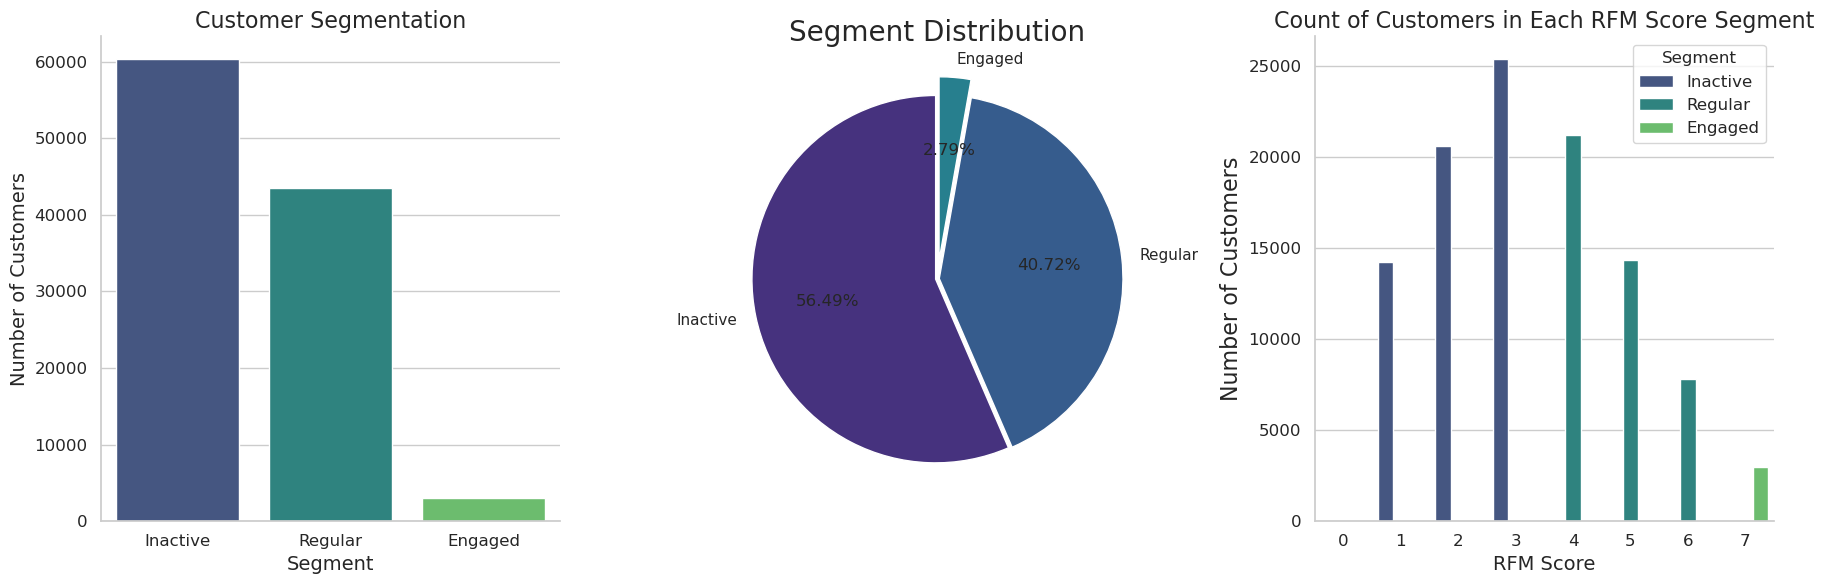

In [179]:
plt.figure(figsize=(18, 6))

# Bar Plot
plt.subplot(1, 3, 1)
sns.countplot(x='segment', data=rfm_df, palette='viridis')
plt.title('Customer Segmentation', fontsize=16)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

# Pie Chart 
plt.subplot(1, 3, 2)
segment_counts = rfm_df['segment'].value_counts()
colors = sns.color_palette('viridis')
explode = (0.01, 0.01, 0.1)  # Explode the 'Engaged' slice
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.2f%%', colors=colors, startangle=90, explode=explode)
plt.title('Segment Distribution', fontsize=20)

# Count Plot
plt.subplot(1, 3, 3)
sns.countplot(x='rfm_score', hue='segment', data=rfm_df, palette='viridis')
plt.title('Count of Customers in Each RFM Score Segment', fontsize=16)
plt.xlabel('RFM Score', fontsize=14)
plt.ylabel('Number of Customers', fontsize=16)
plt.legend(title='Segment', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

# Adjust layout
plt.tight_layout()
plt.show()

### Analyses churn

In [180]:
# Analyze churn
churn_threshold = 180
df['churn'] = (df['recency'] > churn_threshold_days).astype(int)

df['churn'] = df['churn'].astype(str)

# Analyze features for churn prediction
churn_analysis = df.groupby('churn').agg({
    'monetary_value': 'mean',
    'frequency': 'mean',
    'customer_tenure': 'mean',
    'late_deliveries': 'mean',
    'num_orders': 'mean',
    'review_score': 'mean'
}).reset_index()

# Print insights
print("RFM Analysis:")
print(rfm_df.head())

print("\nChurn Analysis:")
print(churn_analysis)

RFM Analysis:
                        customer_id  recency  frequency  monetary_value  \
0  06b8999e2fba1a1fbc88172c00ba8bc7      469          1          146.87   
1  8912fc0c3bbf1e2fbf35819e21706718      293          2          551.58   
2  8912fc0c3bbf1e2fbf35819e21706718      293          2          551.58   
3  f0ac8e5a239118859b1734e1087cbb1f      478          1          140.61   
4  6bc8d08963a135220ed6c6d098831f84      206          1          137.58   

   recency_score  frequency_score  monetary_score  rfm_score   segment  
0              3                0               2          5   Regular  
1              2                0               3          5   Regular  
2              2                0               3          5   Regular  
3              3                0               2          5   Regular  
4              1                0               2          3  Inactive  

Churn Analysis:
  churn  monetary_value  frequency  customer_tenure  late_deliveries  \
0     0 

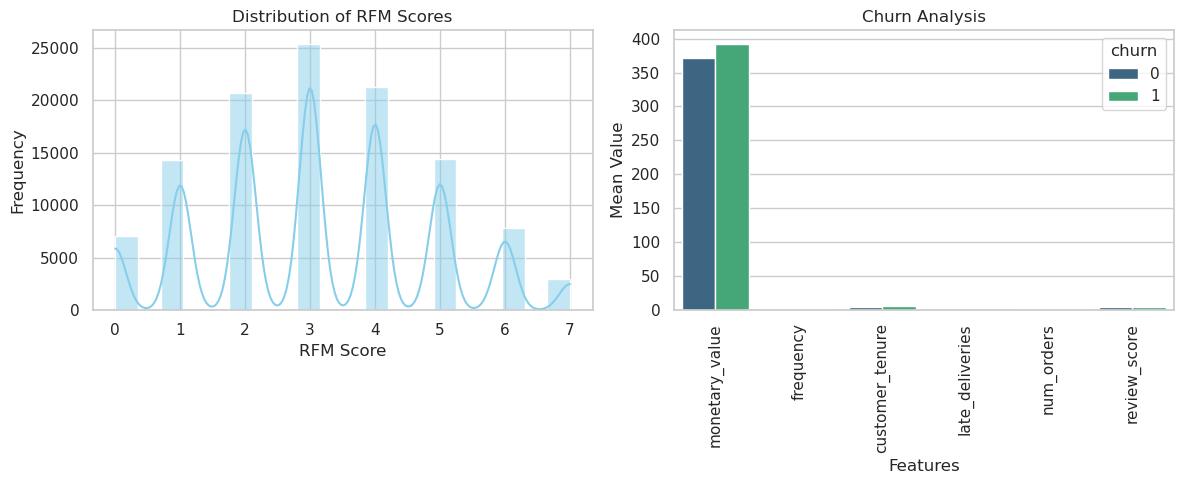

In [181]:
# Create subplots for RFM analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Visualize RFM scores
sns.histplot(data=rfm_df, x='rfm_score', kde=True, bins=20, color='skyblue')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Frequency')

# Create subplots for Churn analysis
plt.subplot(1, 2, 2)

# Visualize churn analysis
churn_analysis_melted = pd.melt(churn_analysis, id_vars='churn', var_name='feature', value_name='mean_value')
sns.barplot(data=churn_analysis_melted, x='feature', y='mean_value', hue='churn', palette='viridis')
plt.title('Churn Analysis')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.xticks(rotation='vertical')
# Display the plots
plt.tight_layout()
plt.show()

## Customer Retention
Customer retention refers to a company’s ability to turn customers into repeat buyers and prevent them from switching to a competitor.

### Why?
Acquiring a new customer can be five to 25 times more expensive than holding on to an existing one.

### Customer retention benefits

    Cost savings: Customer retention is generally more cost-effective than acquiring first-time customers
    Positive word of mouth marketing: Loyal customers are more likely to tell their friends and family about your brand
    A better bottom line: Increasing retention rates by just 5 percent can increase revenue by 25 percent to 95 percent

#### 6 strategies to improve customer retention

    Deliver fast support
    Personalize interactions
    Invest in employees
    Meet customers where they are
    Gather customer feedback
    Incentivise loyalty



### 1. Segmentation Understanding:

#### Regular Customers (Segment: Regular):
   - **Insight:** Moderate recency, frequency, and monetary value.
   - **Strategy:** Implement personalized promotions for related products, maintaining engagement and increasing average order value.

#### Inactive Customers (Segment: Inactive):
   - **Insight:** Low recency, frequency, and monetary value.
   - **Strategy:** Launch reactivation campaigns with special offers and targeted messaging to reignite interest.

### 2. Churn Analysis Insights:

   - **Churned Customers:**
      - **Insight:** Churn associated with late deliveries and review scores.
      - **Strategy:** Address late deliveries promptly, gather feedback, and showcase resolutions to improve customer satisfaction.

### 3. Recency-Frequency-Monetary (RFM) Score Utilization:

   - **Recency Score:**
      - **Insight:** Win-back potential in higher recency scores.
      - **Strategy:** Launch time-sensitive promotions for recent customers, emphasizing exclusive benefits.

   - **Frequency Score:**
      - **Insight:** Low engagement in customers with low frequency scores.
      - **Strategy:** Introduce a loyalty program with tiered benefits to increase engagement.

   - **Monetary Score:**
      - **Insight:** Create VIP programs for high monetary score customers.
      - **Strategy:** Design premium VIP programs with exclusive benefits, aiming to increase the monetary value of moderate-scoring customers.

### 4. RFM Score (Overall) Strategy:

   - **High RFM Score (5-7):**
      - **Insight:** Indicates highly engaged and valuable customers.
      - **Strategy:** Implement an exclusive loyalty program, offering personalized perks, early access to promotions, and special events to maintain their loyalty.

   - **Moderate RFM Score (3-4):**
      - **Insight:** Indicates room for improvement and potential for increased engagement.
      - **Strategy:** Launch targeted promotions and personalized communication to elevate their RFM scores, encouraging more frequent and higher-value transactions.

   - **Low RFM Score (0-2):**
      - **Insight:** Indicates less engaged and lower-value customers.
      - **Strategy:** Implement win-back campaigns, offering special incentives to encourage repeat purchases and regain their interest.

### 5. Customer Experience Enhancement:

   - **Late Deliveries:**
      - **Insight:** Optimize the supply chain to reduce late deliveries.
      - **Strategy:** Implement real-time tracking and proactive communication for better customer satisfaction.

   - **Review Scores:**
      - **Insight:** Positive reviews correlate with customer retention.
      - **Strategy:** Encourage customers to leave positive reviews and address negative ones promptly.

### 6. Communication Strategies:

   - **Personalized Messaging:**
      - **Insight:** Tailor communications based on customer segments and RFM scores.
      - **Strategy:** Use dynamic content in emails showcasing relevant products and promotions based on each customer's past behavior.

   - **Reactivation Campaigns:**
      - **Insight:** Inactive customers show potential for reactivation.
      - **Strategy:** Employ multi-channel communication with personalized incentives to win back inactive customers.

### 7. Retention KPIs and Measurement:

   - **Key Performance Indicators (KPIs):**
      - **Insight:** Monitor customer retention rate, repeat purchase rate, and customer lifetime value.
      - **Strategy:** Regularly track and analyze KPIs to measure the success of campaigns, adjusting strategies based on performance metrics.

   - **Feedback and Surveys:**
      - **Insight:** Customer feedback provides valuable insights.
      - **Strategy:** Conduct regular surveys to gather feedback and make data-driven improvements.

### 8. Continuous Improvement:

   - **Data Analysis:**
      - **Insight:** Regularly analyze customer behavior data for trends.
      - **Strategy:** Adapt strategies based on evolving customer preferences and market dynamics.

   - **Adaptability:**
      - **Insight:** Stay informed about industry changes.
      - **Strategy:** Adapt the retention strategy to align with emerging market trends, maintaining a competitive edge.

### 9. Employee Training and Customer Service:

   - **Training Programs:**
      - **Insight:** Well-trained staff contributes to positive interactions.
      - **Strategy:** Provide ongoing training to customer service teams, empowering them to handle concerns proactively.

   - **Customer Service Excellence:**
      - **Insight:** Customer service excellence positively impacts brand perception.
      - **Strategy:** Implement a customer-centric culture within the organization to ensure excellence in every customer interaction.

### Conclusion:

This retention strategy, enriched with specific insights from RFM and churn analyses, includes a tailored approach for customers based on their overall RFM scores. The goal is to maximize engagement, increase loyalty, and address specific needs of each customer segment. Regular evaluation and adaptability are crucial to sustaining a successful retention strategy in the dynamic landscape of customer preferences and market trends.
